## Recurrent Neural Network

In [1]:
#!conda install -y yfinance
#!conda install -y tensorflow

In [149]:
import eikon as ek  # the Eikon Python wrapper package
import numpy as np
import pandas as pd
import cufflinks as cf  # Cufflinks
import configparser as cp
cf.set_config_file(offline=True)  # set the plotting mode to offline

import math
import datetime
#import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Dropout, 
                                     Activation, Flatten, 
                                     MaxPooling2D, SimpleRNN)
from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [150]:
cfg = cp.ConfigParser()
cfg.read('refinitiv.cfg')
ek.set_app_key(cfg['eikon']['app_id'])

In [151]:
n_steps = 13
n_features = 1

In [152]:
model = Sequential()
model.add(SimpleRNN(512, activation='relu', 
                    input_shape=(n_steps, n_features),
                    return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(256, activation = 'relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [153]:
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mse'])

In [154]:
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [156]:
import datetime as dt
ticker = ['AAPL', 'MSFT']
start = dt.datetime(2019, 1, 1)
end = dt.datetime(2020, 1 ,1)
stock_prices = yf.download(ticker,start=start, end = end, interval='1d')\
               .Close
stock_prices

[*********************100%***********************]  2 of 2 completed


,AAPL,MSFT
Date,,
2019-01-02,39.4800,101.1200
2019-01-03,35.5475,97.4000
2019-01-04,37.0650,101.9300
2019-01-07,36.9825,102.0600
2019-01-08,37.6875,102.8000
...,...,...
2019-12-24,71.0675,157.3800
2019-12-26,72.4775,158.6700
2019-12-27,72.4500,158.9600


In [157]:
from datetime import datetime, timedelta
today = datetime.today()
past = today - timedelta(days=(365))
print(today, past)
stock_prices = ek.get_timeseries(['AAPL.O', 'MSFT.O'], start_date = past, end_date = today, fields='CLOSE', interval="daily")
stock_prices

2022-03-30 06:54:11.580441 2021-03-30 06:54:11.580441


CLOSE,AAPL.O,MSFT.O
Date,,
2021-03-31,122.1500,235.7700
2021-04-01,123.0000,242.3500
2021-04-05,125.9000,249.0700
2021-04-06,126.2100,247.8600
2021-04-07,127.9000,249.9000
...,...,...
2022-03-24,174.0700,304.1000
2022-03-25,174.7200,303.6800
2022-03-28,175.6000,310.7000


In [158]:
diff_stock_prices = stock_prices.diff().dropna()

In [189]:
diff_stock_prices

CLOSE,AAPL.O,MSFT.O
Date,,
2021-04-01,0.8500,6.5800
2021-04-05,2.9000,6.7200
2021-04-06,0.3100,-1.2100
2021-04-07,1.6900,2.0400
2021-04-08,2.4600,3.3500
...,...,...
2022-03-24,3.8600,4.6100
2022-03-25,0.6500,-0.4200
2022-03-28,0.8800,7.0200


In [159]:
split = int(len(diff_stock_prices['AAPL.O'].values) * 0.95)
diff_train_s1 = diff_stock_prices['AAPL.O'].iloc[:split]
diff_test_s1 = diff_stock_prices['AAPL.O'].iloc[split:]
diff_train_s2 = diff_stock_prices['MSFT.O'].iloc[:split]
diff_test_s2 = diff_stock_prices['MSFT.O'].iloc[split:]

In [160]:
X_s1, y_s1 = split_sequence(diff_train_s1, n_steps)
X_s1 = X_s1.reshape((X_s1.shape[0],  X_s1.shape[1], n_features))

In [163]:
#Considering y variable holds numpy array
y_tensor_s1 = tf.convert_to_tensor(y_s1, dtype=tf.int64)
X_tensor_s1 = tf.convert_to_tensor(X_s1, dtype=tf.int64) 

In [164]:
history = model.fit(X_tensor_s1, y_tensor_s1, 
                    epochs=400, batch_size=150, verbose=0, 
                    validation_split = 0.10)

In [165]:
history

In [166]:
start = X_s1[X_s1.shape[0] - n_steps]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [167]:
tempList_s1 = []
for i in range(len(diff_test_s1)):
    x_input = x_input.reshape((1, n_steps, n_features))
    x_input  = tf.convert_to_tensor(x_input, dtype=tf.int64) 
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_s1.append(yhat)

In [168]:
tempList_s1

[array([[1.2627665]], dtype=float32),
 array([[-0.25837883]], dtype=float32),
 array([[-0.17580087]], dtype=float32),
 array([[-2.0332463]], dtype=float32),
 array([[0.3718159]], dtype=float32),
 array([[0.16820784]], dtype=float32),
 array([[-1.1121942]], dtype=float32),
 array([[1.7820791]], dtype=float32),
 array([[-0.49569148]], dtype=float32),
 array([[-0.7917415]], dtype=float32),
 array([[-0.20043665]], dtype=float32),
 array([[0.42244875]], dtype=float32),
 array([[-0.10634093]], dtype=float32)]

In [169]:
X_s2, y_s2 = split_sequence(diff_train_s2, n_steps)
X_s2 = X_s2.reshape((X_s2.shape[0],  X_s2.shape[1],
                         n_features))

In [170]:
#Considering y variable holds numpy array
y_tensor_s2 = tf.convert_to_tensor(y_s2, dtype=tf.int64)
X_tensor_s2 = tf.convert_to_tensor(X_s2, dtype=tf.int64) 

In [171]:
history = model.fit(X_tensor_s2, y_tensor_s2, 
                    epochs=400, batch_size=150, verbose=0, 
                    validation_split = 0.10)

In [172]:
start = X_s2[X_s2.shape[0] - n_steps]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [173]:
tempList_s2 = []
for i in range(len(diff_test_s2)):
    x_input = x_input.reshape((1, n_steps, n_features))
    x_input  = tf.convert_to_tensor(x_input, dtype=tf.int64) 
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_s2.append(yhat)

In [177]:
diff_test_s1, np.array(tempList_s1).flatten()

(Date
 2022-03-14   -4.1100
 2022-03-15    4.4700
 2022-03-16    4.5000
 2022-03-17    1.0300
 2022-03-18    3.3600
 2022-03-21    1.4000
 2022-03-22    3.4400
 2022-03-23    1.3900
 2022-03-24    3.8600
 2022-03-25    0.6500
 2022-03-28    0.8800
 2022-03-29    3.3600
 2022-03-30   -0.1415
 Name: AAPL.O, dtype: Float64,
 array([ 1.2627665 , -0.25837883, -0.17580087, -2.0332463 ,  0.3718159 ,
         0.16820784, -1.1121942 ,  1.7820791 , -0.49569148, -0.7917415 ,
        -0.20043665,  0.42244875, -0.10634093], dtype=float32))

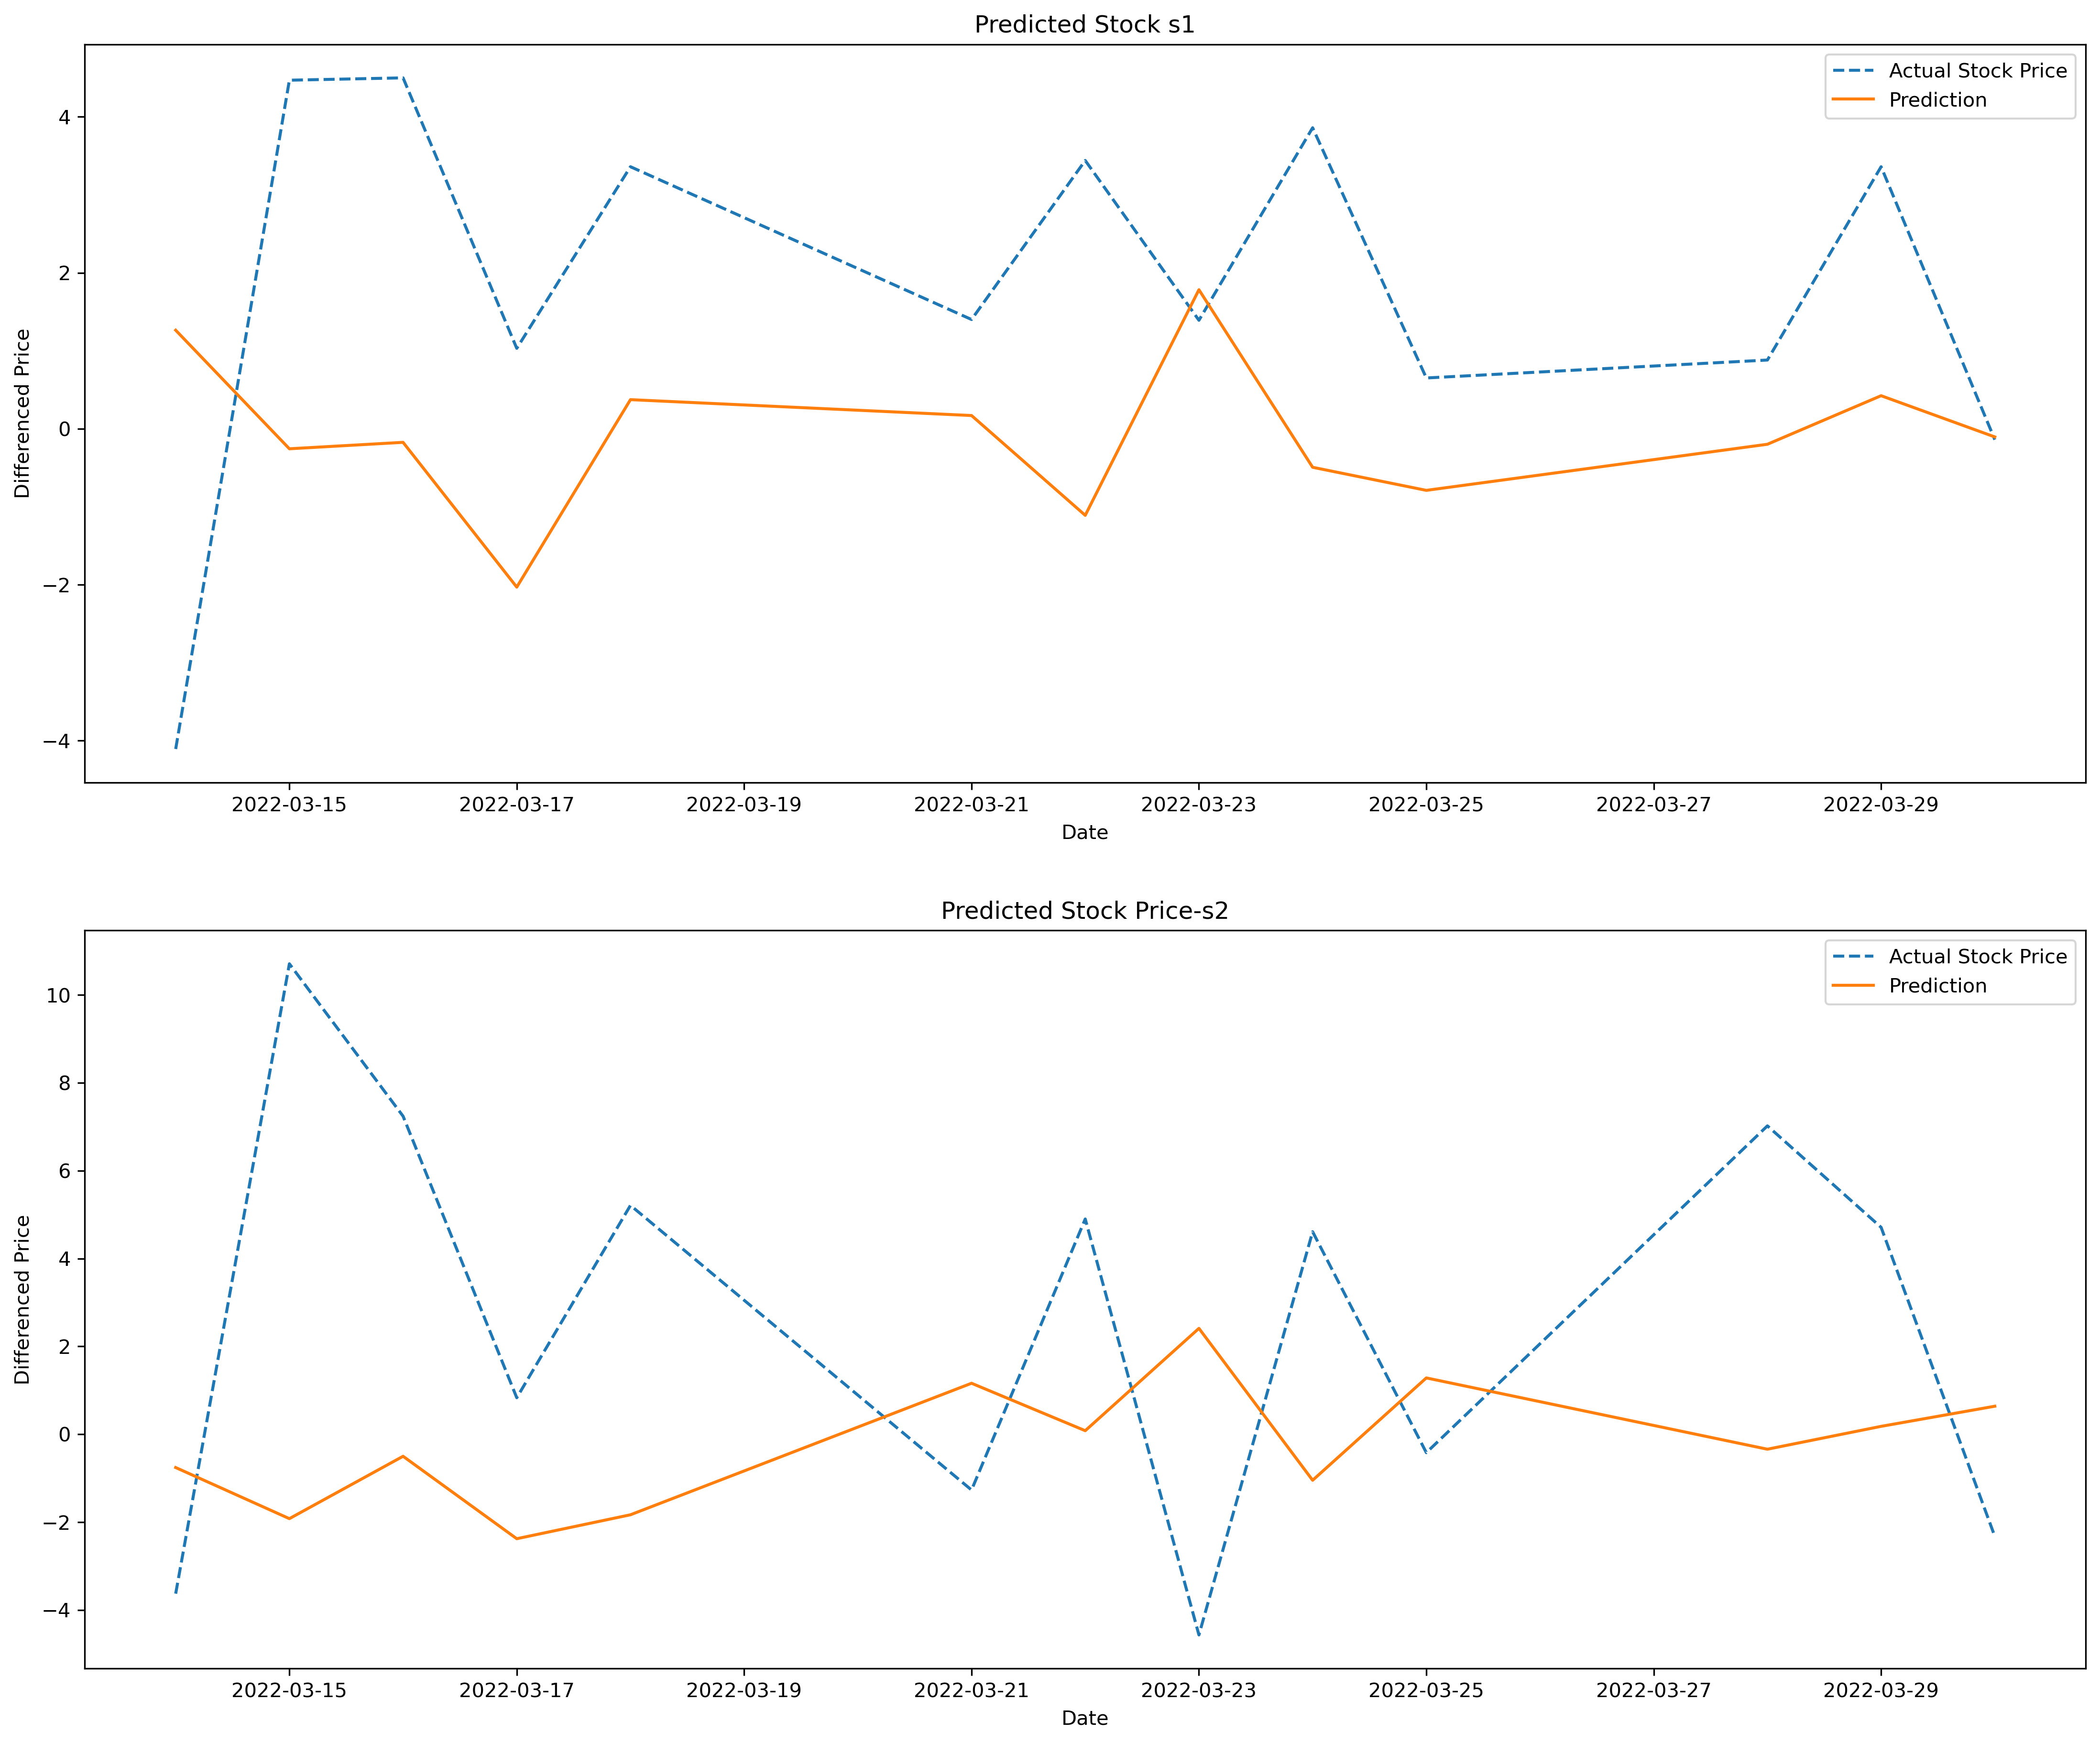

In [174]:
fig, ax = plt.subplots(2,1, figsize=(18,15))
ax[0].plot(diff_test_s1, label='Actual Stock Price', linestyle='--')
ax[0].plot(diff_test_s1.index, np.array(tempList_s1).flatten(),
           linestyle='solid', label="Prediction")
ax[0].set_title('Predicted Stock s1')
ax[0].legend(loc='best')
ax[1].plot(diff_test_s2, label='Actual Stock Price', linestyle='--')
ax[1].plot(diff_test_s2.index,np.array(tempList_s2).flatten(),
           linestyle='solid', label="Prediction")
ax[1].set_title('Predicted Stock Price-s2')
ax[1].legend(loc='best')


for ax in ax.flat:
    ax.set(xlabel='Date', ylabel='Differenced Price')
plt.show()

## LSTM

In [178]:
from tensorflow.keras.layers import LSTM


In [179]:
n_steps = 13
n_features = 1

In [180]:
model = Sequential()
model.add(LSTM(512, activation='relu',
          input_shape=(n_steps, n_features),
          return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [181]:
model.compile(optimizer='rmsprop', loss='mean_squared_error',
              metrics=['mse'])

In [182]:
history = model.fit(X_tensor_s1, y_tensor_s1, 
                    epochs=400, batch_size=150, verbose=0, 
                    validation_split = 0.10)

In [183]:
start = X_s1[X_s1.shape[0] - 13]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [184]:
tempList_s1 = []
for i in range(len(diff_test_s1)):
    x_input = x_input.reshape((1, n_steps, n_features))
    x_input  = tf.convert_to_tensor(x_input, dtype=tf.int64) 
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_s1.append(yhat)

In [185]:
history = model.fit(X_tensor_s2, y_tensor_s2, 
                    epochs=400, batch_size=150, verbose=0, 
                    validation_split = 0.10)

In [186]:
start = X_s2[X_s2.shape[0] - 13]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [187]:
tempList_s2 = []
for i in range(len(diff_test_s2)):
    x_input = x_input.reshape((1, n_steps, n_features))
    x_input  = tf.convert_to_tensor(x_input, dtype=tf.int64) 
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_s2.append(yhat)

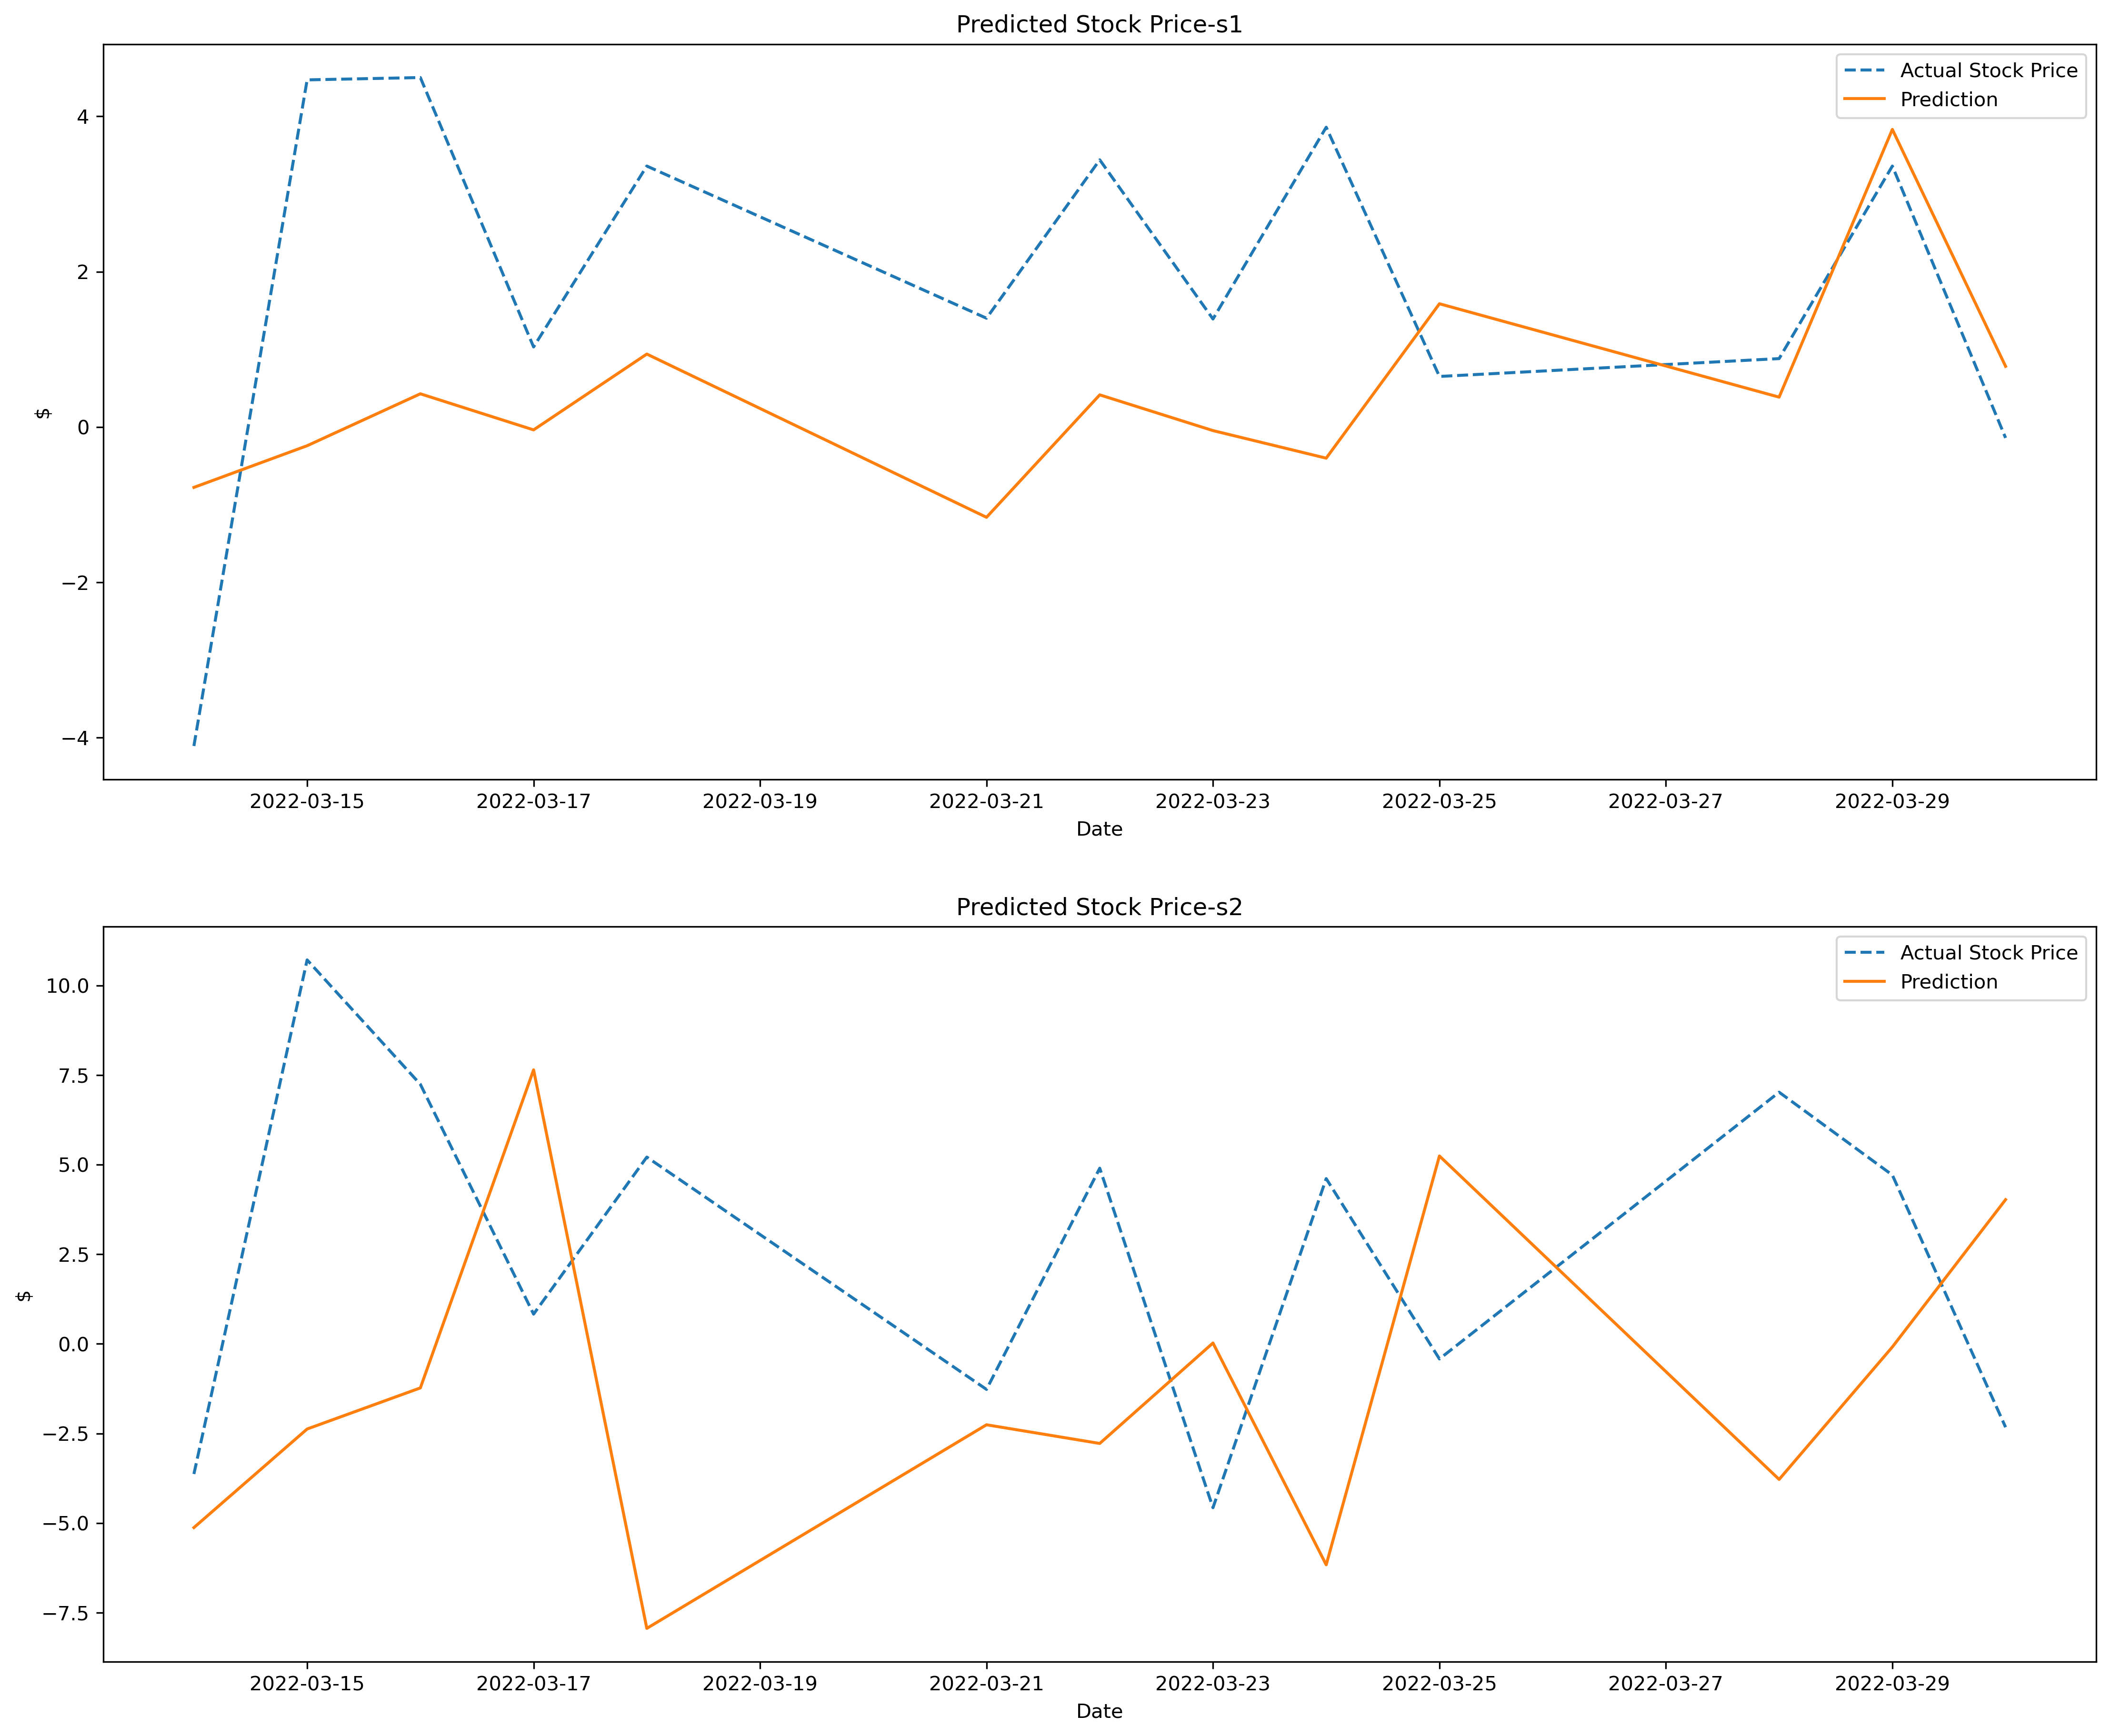

In [188]:
fig, ax = plt.subplots(2, 1, figsize=(18, 15))
ax[0].plot(diff_test_s1, label='Actual Stock Price', linestyle='--')
ax[0].plot(diff_test_s1.index, np.array(tempList_s1).flatten(),
           linestyle='solid', label="Prediction")
ax[0].set_title('Predicted Stock Price-s1')
ax[0].legend(loc='best')
ax[1].plot(diff_test_s2, label='Actual Stock Price', linestyle='--')
ax[1].plot(diff_test_s2.index, np.array(tempList_s2).flatten(),
           linestyle='solid', label="Prediction")
ax[1].set_title('Predicted Stock Price-s2')
ax[1].legend(loc='best')

for ax in ax.flat:
    ax.set(xlabel='Date', ylabel='$')
plt.show()